In [1]:
# pennylane : quantum circuit & simulation
import pennylane as qml

# pennylane numpy :autograd
from pennylane import numpy as np

# Openfermionpyscf : Hamiltonian construction
import openfermion as of
from openfermionpyscf import run_pyscf
from openfermion.chem import MolecularData
from openfermion.transforms import binary_code_transform,checksum_code
from openfermion.transforms import get_fermion_operator
from openfermion.linalg import eigenspectrum
from openfermion.transforms import normal_ordered, reorder
from openfermion.utils import up_then_down

from qiskit_aer import AerSimulator
from qiskit_aer import noise
from qiskit_aer.noise import NoiseModel

# default numpy
import numpy as npy
import itertools


import pickle

In [2]:

def H2_hamiltonian():
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7))]
    molecule = MolecularData(geometry, 'sto-3g', 1, description="0.74")
    molecule = run_pyscf(molecule)
    molecular_hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian = normal_ordered(get_fermion_operator(molecular_hamiltonian))
    return hamiltonian

hamiltonian = H2_hamiltonian()


up_down_save_two = binary_code_transform(reorder(hamiltonian,up_then_down), 2*checksum_code(2,1))
print(up_down_save_two)
print("the eigenspectrum of the transformed hamiltonian")
print(eigenspectrum(up_down_save_two))
E_ans_07=eigenspectrum(up_down_save_two)

-0.2879450776015001 [] +
0.17900057606140632 [X0 X1] +
0.42045567978280335 [Z0] +
0.011507402176827053 [Z0 Z1] +
0.42045567978280335 [Z1]
the eigenspectrum of the transformed hamiltonian
[-1.13618945 -0.47845306 -0.1204519   0.5833141 ]


In [3]:
# Noise Model
with open('ibm_manila_properties_new.pickle', 'rb') as f:
    D_data = pickle.load(f)
c_map=[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]    

In [4]:
# Data type tranformation  (openfermion <-> pennylane)
Ham_in=qml.import_operator(up_down_save_two)
print(Ham_in)

  (-0.2879450776015001) [I0]
+ (0.42045567978280335) [Z0]
+ (0.42045567978280335) [Z1]
+ (0.011507402176827053) [Z0 Z1]
+ (0.17900057606140632) [X0 X1]


In [5]:
a_in=np.array([4,3,2,1])/np.linalg.norm(np.array([4,3,2,1]))
a_in

tensor([0.73029674, 0.54772256, 0.36514837, 0.18257419], requires_grad=True)

In [6]:
E_single_pt=sum(a_in**2*E_ans_07)
print(E_single_pt)

-0.7461200759754488


In [7]:
a_in_cb=np.array([4,2,3,1])/np.linalg.norm(np.array([4,2,3,1]))
a_in_cb

tensor([0.73029674, 0.36514837, 0.54772256, 0.18257419], requires_grad=True)

# Noiseless

In [8]:
# Number of qubits 
N_qubits=2
dev22 = qml.device("default.qubit", wires=N_qubits*2)

@qml.qnode(dev22,grad_on_execution='device',diff_method="parameter-shift")
def pvqe_exact(params_in):
    
    # QSP
    qml.QubitStateVector(np.array(a_in_cb,requires_grad=False), wires=range(2))
    qml.Barrier(wires=range(2))
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[1,3])
    qml.Barrier(wires=range(4))
    
    # guccd
    qml.RX(np.pi/2,wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[1]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.RX(-np.pi/2,wires=1) 
    
    qml.RX(np.pi/2,wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[0]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=1)
    qml.RX(-np.pi/2,wires=0) 

    return qml.expval(Ham_in)

(<Figure size 1600x500 with 1 Axes>, <Axes: >)


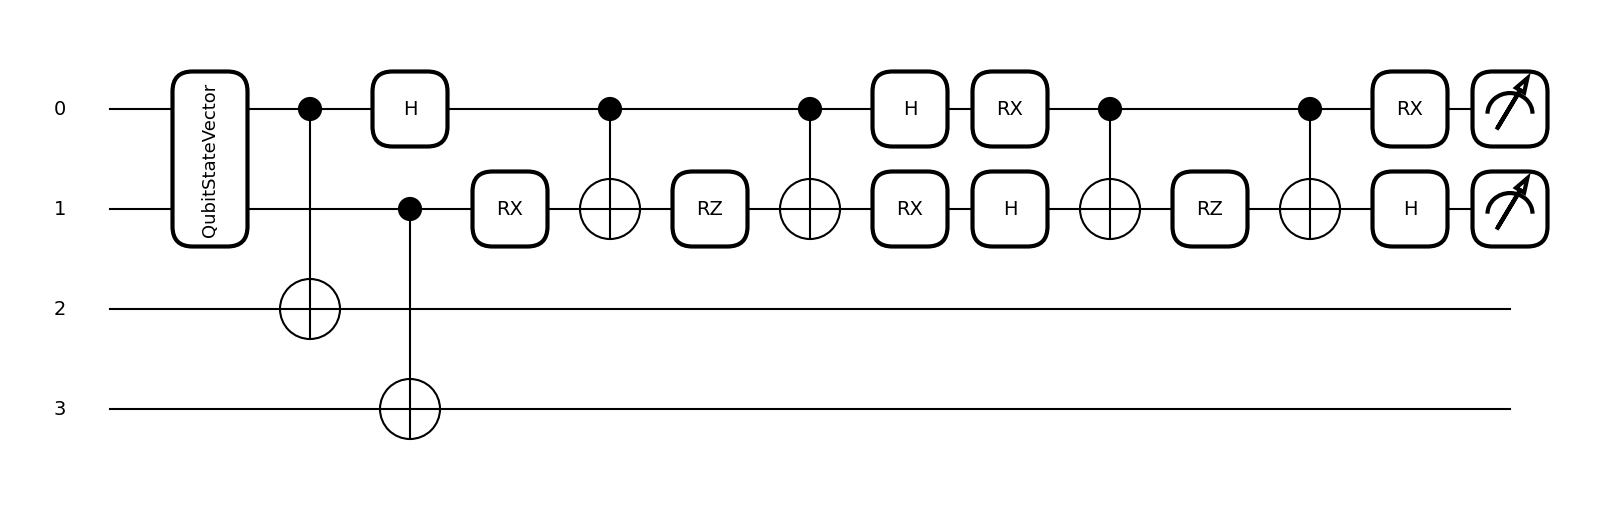

In [9]:
#circuit
params=np.random.random(2)
print(qml.draw_mpl(pvqe_exact,expansion_strategy='device')(params))

In [10]:
# Set up a optimizer, and run the pvqe
lr=0.03
b1=0.9
b2=0.999
opt = qml.AdamOptimizer(stepsize=lr,beta1=b1,beta2=b2)
max_iterations = 2000
conv_tol = 1e-8

print("Adam setting: ",'Learning rate: ',lr,'beta1: ',b1,'beta2: ',b2, 'eps: ',1e-8,'\n')

Adam setting:  Learning rate:  0.03 beta1:  0.9 beta2:  0.999 eps:  1e-08 



In [11]:
EnsembleE=[]
#params = np.random.random(shape)
#params=np.random.random(2)
params=np.zeros(2)
print("Initial parameters: ", params,'\n')

params_set=[]
for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(pvqe_exact, params)
    params_set.append(params)
    Energy=pvqe_exact(params)
    EnsembleE.append(Energy)
    conv = np.abs(EnsembleE[-1] - prev_energy)

    if n % 10 == 0:
        print(f"Step = {n},  Ensemble Energy = {EnsembleE[-1]:.9f} Ha")
    if conv <= conv_tol:
        print(f"Step = {n},  Ensemble Energy = {EnsembleE[-1]:.9f} Ha")
        break
print('\n')        
print('E:', EnsembleE[-1])
print('Final patameters: ', params_set[-1],'\n')
print('Difference:', EnsembleE[-1]-E_single_pt)

Initial parameters:  [0. 0.] 

Step = 0,  Ensemble Energy = 0.120307026 Ha
Step = 10,  Ensemble Energy = -0.272218747 Ha
Step = 20,  Ensemble Energy = -0.689699741 Ha
Step = 30,  Ensemble Energy = -0.687110136 Ha
Step = 40,  Ensemble Energy = -0.709984087 Ha
Step = 50,  Ensemble Energy = -0.725347078 Ha
Step = 60,  Ensemble Energy = -0.728956100 Ha
Step = 70,  Ensemble Energy = -0.734845333 Ha
Step = 80,  Ensemble Energy = -0.738084947 Ha
Step = 90,  Ensemble Energy = -0.740977356 Ha
Step = 100,  Ensemble Energy = -0.742949690 Ha
Step = 110,  Ensemble Energy = -0.744287586 Ha
Step = 120,  Ensemble Energy = -0.745129636 Ha
Step = 130,  Ensemble Energy = -0.745613187 Ha
Step = 140,  Ensemble Energy = -0.745878453 Ha
Step = 150,  Ensemble Energy = -0.746011850 Ha
Step = 160,  Ensemble Energy = -0.746074989 Ha
Step = 170,  Ensemble Energy = -0.746102766 Ha
Step = 180,  Ensemble Energy = -0.746114001 Ha
Step = 190,  Ensemble Energy = -0.746118175 Ha
Step = 200,  Ensemble Energy = -0.7461195

In [12]:
# Number of qubits 
N_qubits=2
dev2 = qml.device("default.qubit", wires=N_qubits)
@qml.qnode(dev2,grad_on_execution='device',diff_method="parameter-shift")
def extract_exact(ind_vector,params_in):
    
    # QSP
    qml.BasisState(np.array(ind_vector,requires_grad=False), wires=range(N_qubits))
    # guccd
    qml.RX(np.pi/2,wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[1]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.RX(-np.pi/2,wires=1) 
    
    qml.RX(np.pi/2,wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[0]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=1)
    qml.RX(-np.pi/2,wires=0)   

    return qml.expval(Ham_in)

In [13]:
N_qubits=2
dev2 = qml.device("default.qubit", wires=N_qubits)
@qml.qnode(dev2,grad_on_execution='device',diff_method="parameter-shift")
def QSP_test(ind_vector):
    
    # QSP
    qml.BasisState(np.array(ind_vector,requires_grad=False), wires=range(N_qubits))
    return qml.state()

In [14]:
inputstates=[[0,0],[1,0],[0,1],[1,1]]

In [15]:
for i in range(len(inputstates)):
    print(extract_exact(inputstates[i],params_set[-1]))

-1.1361894540025304
-0.47845278813881553
-0.12045217141783829
0.5833141031531852


### Noise Model

In [16]:
coupling_map = c_map
noise_model = NoiseModel.from_backend_properties(D_data,readout_error=False)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'cx', 'id', 'x', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,))]


In [17]:
dev_noise = qml.device('qiskit.aer', wires=4, noise_model=noise_model,shots=10000)
@qml.qnode(dev_noise,grad_on_execution='device',diff_method="parameter-shift")
def pvqe_noise(params_in):
    
    # QSP
    qml.QubitStateVector(np.array(a_in_cb,requires_grad=False), wires=range(2))
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[1,3])

    qml.RX(np.pi/2,wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[1]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.RX(-np.pi/2,wires=1) 
    
    qml.RX(np.pi/2,wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[0]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=1)
    qml.RX(-np.pi/2,wires=0) 

 
    return qml.expval(Ham_in)

In [18]:
max_iterations = 500
conv_tol=1e-6
opt2 = qml.SPSAOptimizer(maxiter=max_iterations)

In [19]:
EnsembleEn=[]
params=np.zeros(2)

print("Initial parameters: ", params,'\n')

params_set_noise=[]
for n in range(max_iterations):
    params, prev_energy = opt2.step_and_cost(pvqe_noise, params)
    params_set_noise.append(params)
    Energy=pvqe_noise(params)
    EnsembleEn.append(Energy)
    conv = np.abs(EnsembleEn[-1] - prev_energy)

    if n % 10 == 0:
        print(f"Step = {n},  Ensemble Energy = {EnsembleEn[-1]:.9f} Ha")
    if conv <= conv_tol:
        print(f"Step = {n},  Ensemble Energy = {EnsembleEn[-1]:.9f} Ha")
        break
print('\n')        
print('Final patameters: ', params_set_noise[-1],'\n')

Initial parameters:  [0. 0.] 

Step = 0,  Ensemble Energy = 0.112413956 Ha
Step = 10,  Ensemble Energy = 0.037405802 Ha
Step = 20,  Ensemble Energy = -0.284970341 Ha
Step = 30,  Ensemble Energy = -0.606970261 Ha
Step = 40,  Ensemble Energy = -0.687885826 Ha
Step = 50,  Ensemble Energy = -0.698930854 Ha
Step = 60,  Ensemble Energy = -0.701566803 Ha
Step = 70,  Ensemble Energy = -0.713490135 Ha
Step = 80,  Ensemble Energy = -0.704092374 Ha
Step = 90,  Ensemble Energy = -0.710473773 Ha
Step = 100,  Ensemble Energy = -0.714892776 Ha
Step = 110,  Ensemble Energy = -0.707121869 Ha
Step = 120,  Ensemble Energy = -0.709577024 Ha
Step = 130,  Ensemble Energy = -0.702244730 Ha
Step = 140,  Ensemble Energy = -0.701262071 Ha
Step = 150,  Ensemble Energy = -0.699512447 Ha
Step = 160,  Ensemble Energy = -0.723541685 Ha
Step = 170,  Ensemble Energy = -0.729096932 Ha
Step = 180,  Ensemble Energy = -0.712297009 Ha
Step = 190,  Ensemble Energy = -0.713597616 Ha
Step = 200,  Ensemble Energy = -0.71166139

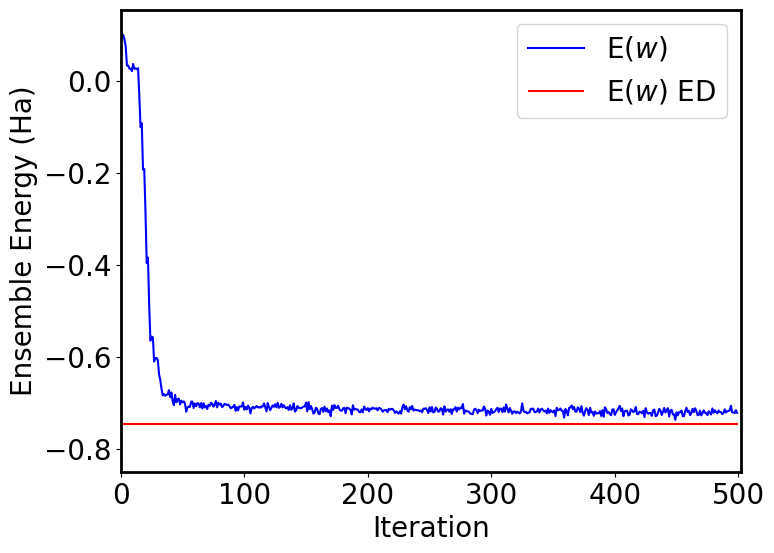

In [20]:
import matplotlib.pyplot as plt


x_params_set_noise = [*range(0,len(params_set_noise))]
y_EnsembleEn = EnsembleEn



plt.figure(figsize=(8, 6)) 
plt.plot(x_params_set_noise, y_EnsembleEn,label="E(${w}$)",color='blue')
plt.hlines(E_single_pt,1,500,color="r",label='E(${w}$) ED')



plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Ensemble Energy (Ha)',fontsize=20)


plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)


TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)

plt.xlim(left=0,right=502)
plt.ylim(bottom=-0.85) 
    
plt.legend(loc = 'upper right',fontsize=20,markerscale=2)     


plt.show()

In [21]:
dev_noise = qml.device('qiskit.aer', wires=N_qubits, noise_model=noise_model,shots=10000)
@qml.qnode(dev_noise,grad_on_execution='device',diff_method="parameter-shift")
def pvqe_En(ind_vector,params_in):
    
    # QSP
    qml.BasisState(np.array(ind_vector), wires=range(N_qubits))
    # guccd
    qml.RX(np.pi/2,wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[1]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    qml.RX(-np.pi/2,wires=1) 
    
    qml.RX(np.pi/2,wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(params_in[0]*2,wires=1)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=1)
    qml.RX(-np.pi/2,wires=0)   

    return qml.expval(Ham_in)

In [22]:
Noise_E1=[]
Noise_E2=[]
Noise_E3=[]
Noise_E4=[]

for i in range(len(params_set_noise)):
    Noise_E1.append(pvqe_En(inputstates[0],params_set_noise[i]))
    Noise_E2.append(pvqe_En(inputstates[1],params_set_noise[i]))
    Noise_E3.append(pvqe_En(inputstates[2],params_set_noise[i]))
    Noise_E4.append(pvqe_En(inputstates[3],params_set_noise[i]))

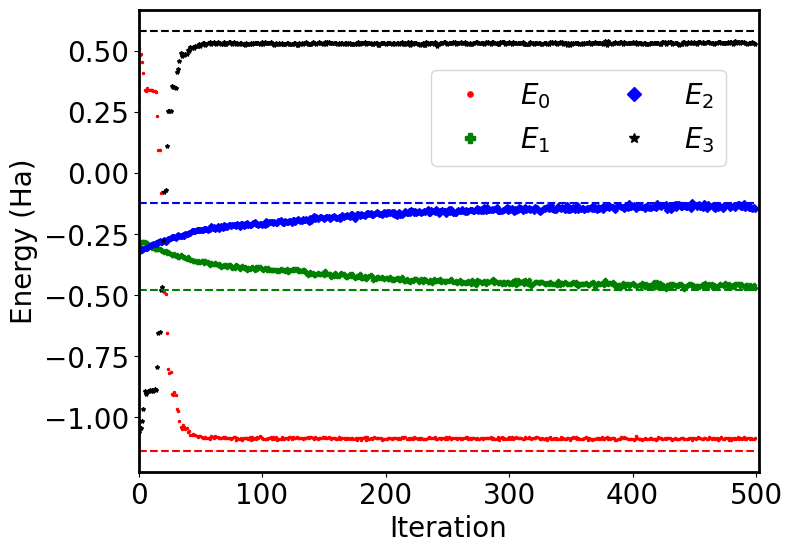

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6)) 

plt.plot(x_params_set_noise, Noise_E1,'r.',label='$E_0$',markersize=3)
plt.plot(x_params_set_noise, Noise_E2,'gP',label='$E_1$',markersize=3)
plt.plot(x_params_set_noise, Noise_E3,'bD',label='$E_2$',markersize=3)
plt.plot(x_params_set_noise, Noise_E4,'k*',label='$E_3$',markersize=3)


linestyle = 'dashed'
plt.hlines(E_ans_07[0],0,500,color="r",linestyle=linestyle)
plt.hlines(E_ans_07[1],0,500,color="g",linestyle=linestyle)
plt.hlines(E_ans_07[2],0,500,color="b",linestyle=linestyle)
plt.hlines(E_ans_07[3],0,500,color="k",linestyle=linestyle)


plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Energy (Ha)',fontsize=20)


plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)


plt.xlim(left=0,right=502)
plt.xlim(left=0)
plt.show()